# Train YOLO11 Models

**Based on:** [EdjeElectronics YOLO Training Tutorial](https://youtu.be/r0RspiLG260)

**GitHub:** [Train and Deploy YOLO Models](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models)

## Introduction

This notebook uses [Ultralytics](https://docs.ultralytics.com/) to train YOLO11 object detection models with a custom dataset. At the end of this notebook, you'll have a custom YOLO model ready for deployment.

### What You'll Learn

1. How to prepare datasets in YOLO format
2. How to train YOLO11 models
3. How to validate and test your trained models
4. How to deploy models for inference

### Dataset Options

You can use:
- **Your own custom dataset** (recommended for best results)
- **Pre-made datasets** like candy detection or coin detection
- **Roboflow Universe datasets**

---

## 1. Setup and Imports

In [1]:
import os
import sys
import shutil
import random
import yaml
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Check if we're in a notebook subdirectory
if Path.cwd().name == 'notebooks':
    os.chdir('..')

print(f"Working directory: {os.getcwd()}")
print(f"Python version: {sys.version}")

Working directory: /Users/hojinjang/work/trying-finetuning
Python version: 3.11.13 (main, Jul  8 2025, 20:42:09) [Clang 20.1.4 ]


## 2. Install Ultralytics

Install the Ultralytics library which provides YOLO11, YOLOv8, and YOLOv5 models.

In [2]:
!pip install -q ultralytics

from ultralytics import YOLO
import torch

print(f"\n{'='*60}")
print("Installation Complete!")
print(f"{'='*60}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"{'='*60}\n")


Installation Complete!
PyTorch version: 2.9.0
CUDA available: False



## 3. Prepare Dataset

### Dataset Structure

YOLO requires the following folder structure:

```
custom_data/
├── images/          # Your images (JPG or PNG)
├── labels/          # YOLO format labels (.txt)
└── classes.txt      # List of class names (one per line)
```

### Label Format

Each `.txt` label file contains one line per object:
```
<class_id> <x_center> <y_center> <width> <height>
```
All values are normalized (0-1) relative to image dimensions.

### Options for Getting Data

**Option 1:** Use your own custom dataset (place it in `custom_data/` folder)

**Option 2:** Download a pre-made dataset (uncomment one of the commands below)

In [3]:
# Option 2: Download pre-made dataset
# Uncomment ONE of the following lines:

# Candy detection dataset (162 images)
### !wget -O data.zip https://s3.us-west-1.amazonaws.com/evanjuras.com/resources/candy_data_06JAN25.zip

# Coin detection dataset (750 images)
# !wget -O data.zip https://s3.us-west-1.amazonaws.com/evanjuras.com/resources/YOLO_coin_data_12DEC30.zip

# If you downloaded a dataset, unzip it:
###!unzip -q data.zip -d custom_data

print("If you're using your own dataset, make sure it's in the custom_data/ folder!")


If you're using your own dataset, make sure it's in the custom_data/ folder!


## 4. Split Dataset into Train and Validation

We'll split the dataset into 90% training and 10% validation.

In [4]:
def train_val_split(datapath, train_pct=0.9):
    """
    Split dataset into train and validation folders.
    
    Args:
        datapath: Path to custom_data folder containing images/ and labels/
        train_pct: Percentage of data to use for training (default 0.9)
    """
    datapath = Path(datapath)
    images_dir = datapath / 'images'
    labels_dir = datapath / 'labels'
    
    if not images_dir.exists():
        print(f"❌ Error: {images_dir} does not exist!")
        return
    
    # Create output directories
    data_root = Path('data')
    for split in ['train', 'validation']:
        (data_root / split / 'images').mkdir(parents=True, exist_ok=True)
        (data_root / split / 'labels').mkdir(parents=True, exist_ok=True)
    
    # Get all image files
    image_files = list(images_dir.glob('*.jpg')) + list(images_dir.glob('*.png')) + list(images_dir.glob('*.jpeg'))
    print(f"Found {len(image_files)} images")
    
    # Shuffle and split
    random.shuffle(image_files)
    split_idx = int(len(image_files) * train_pct)
    train_files = image_files[:split_idx]
    val_files = image_files[split_idx:]
    
    print(f"Train: {len(train_files)} images")
    print(f"Validation: {len(val_files)} images")
    
    # Copy files
    for file_list, split in [(train_files, 'train'), (val_files, 'validation')]:
        for img_file in file_list:
            # Copy image
            shutil.copy2(img_file, data_root / split / 'images' / img_file.name)
            
            # Copy corresponding label
            label_file = labels_dir / f"{img_file.stem}.txt"
            if label_file.exists():
                shutil.copy2(label_file, data_root / split / 'labels' / label_file.name)
    
    print("\n✅ Dataset split complete!")
    print(f"Output directory: {data_root.absolute()}")

# Run the split
train_val_split('custom_data', train_pct=0.9)

Found 162 images
Train: 145 images
Validation: 17 images

✅ Dataset split complete!
Output directory: /Users/hojinjang/work/trying-finetuning/data


## 5. Visualize Training Samples

Classes: ['MMs_peanut', 'MMs_regular', 'airheads', 'gummy_worms', 'milky_way', 'nerds', 'skittles', 'snickers', 'starbust', 'three_musketeers', 'twizzlers']



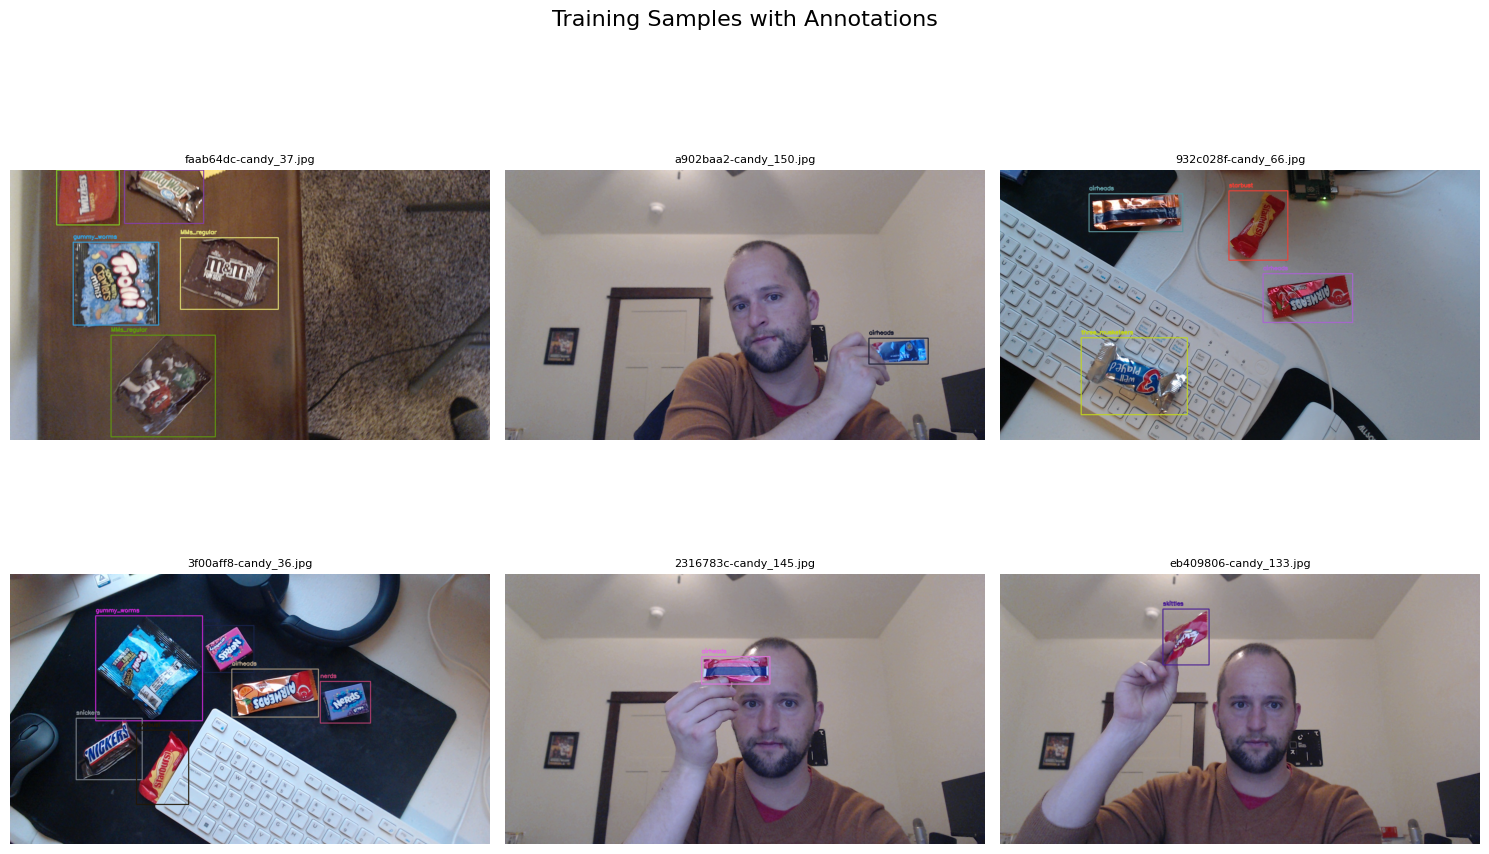

In [5]:
def visualize_yolo_sample(image_path, label_path, class_names):
    """
    Visualize a single YOLO training sample.
    """
    # Read image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]
    
    # Read labels
    if label_path.exists():
        with open(label_path, 'r') as f:
            labels = f.readlines()
        
        # Draw bounding boxes
        for label in labels:
            parts = label.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])
                
                # Convert normalized coordinates to pixel coordinates
                x_center *= w
                y_center *= h
                width *= w
                height *= h
                
                # Calculate box corners
                x1 = int(x_center - width / 2)
                y1 = int(y_center - height / 2)
                x2 = int(x_center + width / 2)
                y2 = int(y_center + height / 2)
                
                # Draw box
                color = tuple(np.random.randint(0, 255, 3).tolist())
                cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                
                # Add label
                label_text = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                cv2.putText(image, label_text, (x1, y1 - 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return image

# Load class names
classes_file = Path('custom_data/classes.txt')
if classes_file.exists():
    with open(classes_file, 'r') as f:
        class_names = [line.strip() for line in f.readlines() if line.strip()]
    
    print(f"Classes: {class_names}\n")
    
    # Visualize a few samples
    train_images_dir = Path('data/train/images')
    train_labels_dir = Path('data/train/labels')
    
    if train_images_dir.exists():
        image_files = list(train_images_dir.glob('*.jpg')) + list(train_images_dir.glob('*.png'))
        
        # Show 6 random samples
        num_samples = min(6, len(image_files))
        sample_indices = np.random.choice(len(image_files), num_samples, replace=False)
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        
        for idx, sample_idx in enumerate(sample_indices):
            img_path = image_files[sample_idx]
            label_path = train_labels_dir / f"{img_path.stem}.txt"
            
            img = visualize_yolo_sample(img_path, label_path, class_names)
            
            axes[idx].imshow(img)
            axes[idx].axis('off')
            axes[idx].set_title(f"{img_path.name}", fontsize=8)
        
        plt.suptitle('Training Samples with Annotations', fontsize=16)
        plt.tight_layout()
        plt.show()
else:
    print("⚠️ classes.txt not found. Please create it in custom_data/classes.txt")

## 6. Create YOLO Configuration File

Create a `data.yaml` file that tells YOLO where to find the training and validation data.

In [6]:
def create_data_yaml(path_to_classes_txt, path_to_data_yaml):
    """
    Create YOLO data.yaml configuration file.
    """
    # Read classes
    if not os.path.exists(path_to_classes_txt):
        print(f'❌ classes.txt not found at {path_to_classes_txt}')
        print('Please create a classes.txt file with one class name per line.')
        return
    
    with open(path_to_classes_txt, 'r') as f:
        classes = [line.strip() for line in f.readlines() if line.strip()]
    
    num_classes = len(classes)
    
    # Create data dictionary
    data = {
        'path': str(Path('data').absolute()),
        'train': 'train/images',
        'val': 'validation/images',
        'nc': num_classes,
        'names': classes
    }
    
    # Write YAML file
    with open(path_to_data_yaml, 'w') as f:
        yaml.dump(data, f, sort_keys=False)
    
    print(f'✅ Created config file at {path_to_data_yaml}')
    print(f'\nNumber of classes: {num_classes}')
    print(f'Classes: {classes}')
    
    return data

# Create the YAML file
classes_txt_path = 'custom_data/classes.txt'
data_yaml_path = 'data.yaml'

config = create_data_yaml(classes_txt_path, data_yaml_path)

print('\n📄 Configuration file contents:\n')
!cat data.yaml

✅ Created config file at data.yaml

Number of classes: 11
Classes: ['MMs_peanut', 'MMs_regular', 'airheads', 'gummy_worms', 'milky_way', 'nerds', 'skittles', 'snickers', 'starbust', 'three_musketeers', 'twizzlers']

📄 Configuration file contents:

path: /Users/hojinjang/work/trying-finetuning/data
train: train/images
val: validation/images
nc: 11
names:
- MMs_peanut
- MMs_regular
- airheads
- gummy_worms
- milky_way
- nerds
- skittles
- snickers
- starbust
- three_musketeers
- twizzlers


## 7. Configure Training Parameters

### Key Parameters:

**Model Size (`model`):**
- `yolo11n.pt` - Nano (fastest, lowest accuracy)
- `yolo11s.pt` - Small (good balance) ⭐ **Recommended for starting**
- `yolo11m.pt` - Medium
- `yolo11l.pt` - Large
- `yolo11x.pt` - Extra Large (slowest, highest accuracy)

**Epochs:**
- Small dataset (<200 images): 60 epochs
- Large dataset (>200 images): 40 epochs

**Image Size (`imgsz`):**
- Standard: 640x640
- Faster/Lower resolution: 480x480
- Higher accuracy: 1280x1280

In [7]:
# Training configuration
TRAINING_CONFIG = {
    'data': 'data.yaml',          # Path to data config
    'model': 'yolo11s.pt',        # Model size
    'epochs': 10,                 # Number of training epochs
    'imgsz': 640,                 # Image size
    'batch': -1,                  # Batch size (-1 for auto)
    # 'device': 0 if torch.cuda.is_available() else 'cpu',  # Use GPU if available
    'device': 'mps',
    'project': 'runs/detect',     # Project directory
    'name': 'train',              # Experiment name
    'exist_ok': True,             # Overwrite existing
    # 'patience': 50,               # Early stopping patience
    'save': True,                 # Save checkpoints
    'plots': True,                # Save training plots
}

print("Training Configuration:")
print("=" * 60)
for key, value in TRAINING_CONFIG.items():
    print(f"  {key:15s}: {value}")
print("=" * 60)

Training Configuration:
  data           : data.yaml
  model          : yolo11s.pt
  epochs         : 10
  imgsz          : 640
  batch          : -1
  device         : mps
  project        : runs/detect
  name           : train
  exist_ok       : True
  save           : True
  plots          : True


## 8. Train the Model

This will download the pre-trained YOLO11 model and fine-tune it on your custom dataset.

**Note:** Training will take some time depending on your hardware:
- GPU: ~10-30 minutes
- CPU: ~1-3 hours

In [8]:
# Load model
model = YOLO(TRAINING_CONFIG['model'])

print("\n🚀 Starting training...\n")

# Train the model
results = model.train(**TRAINING_CONFIG)

print("\n" + "="*60)
print("✅ Training Complete!")
print("="*60)
print(f"\nBest model saved at: runs/detect/train/weights/best.pt")
print(f"Training plots saved at: runs/detect/train/results.png")


🚀 Starting training...

New https://pypi.org/project/ultralytics/8.3.221 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.219 🚀 Python-3.11.13 torch-2.9.0 MPS (Apple M2)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=Fals

## 9. Visualize Training Results

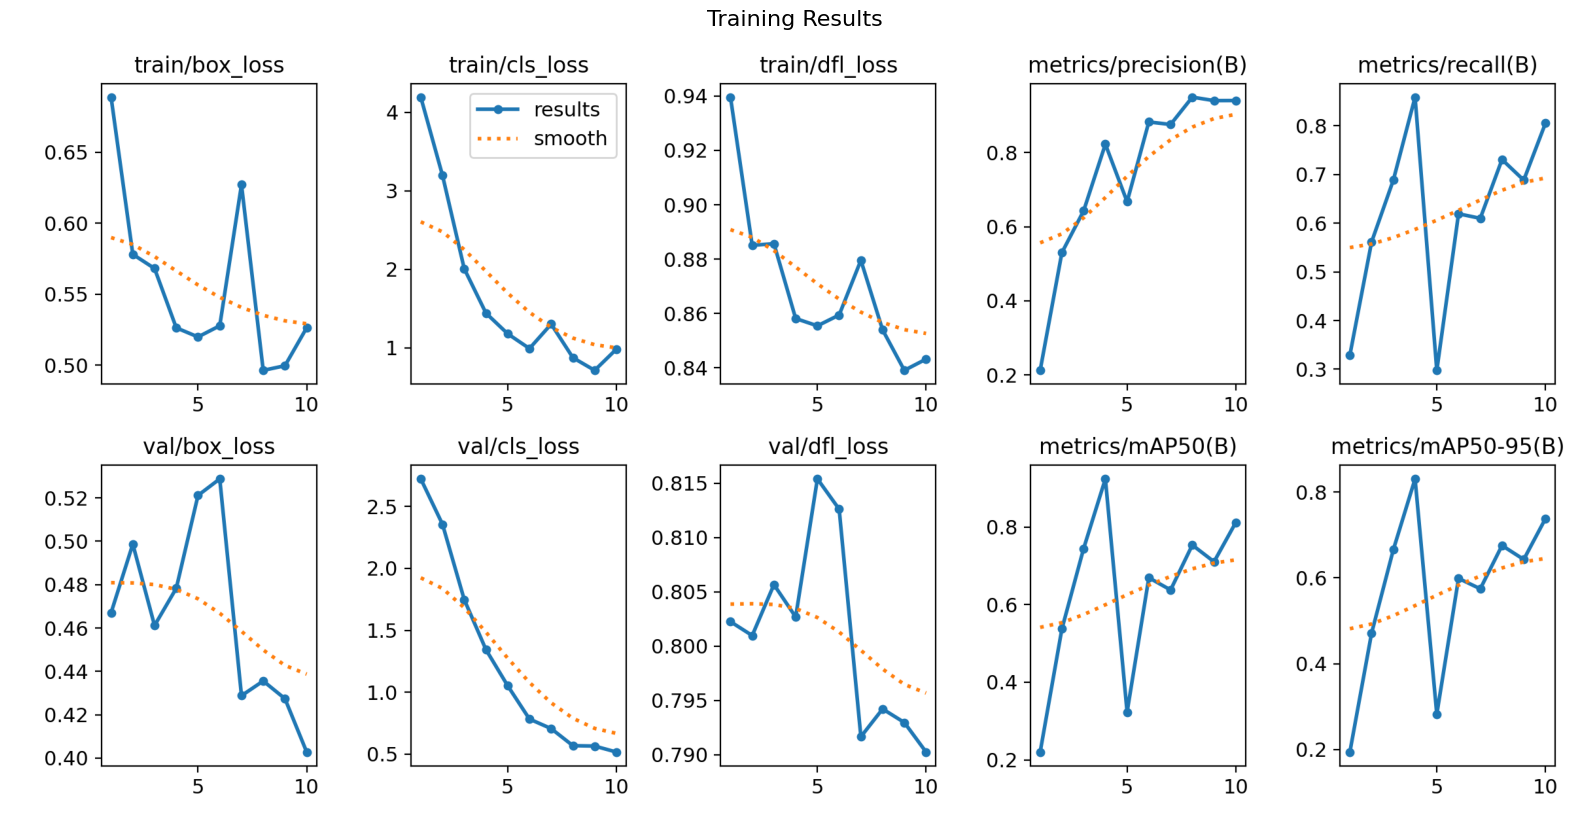

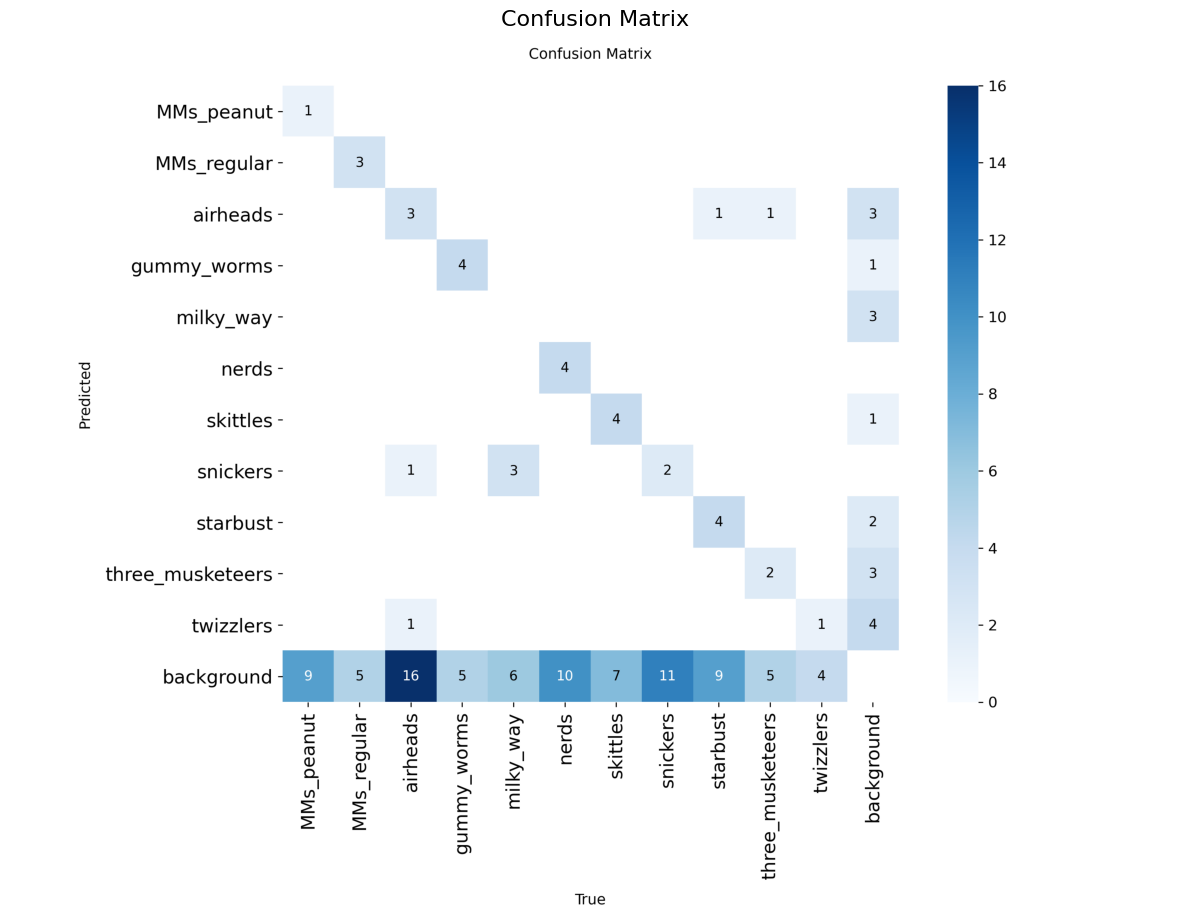

In [9]:
# Display training results
results_plot = Path('runs/detect/train/results.png')
if results_plot.exists():
    img = plt.imread(str(results_plot))
    plt.figure(figsize=(16, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Training Results', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Results plot not found")

# Display confusion matrix
confusion_matrix = Path('runs/detect/train/confusion_matrix.png')
if confusion_matrix.exists():
    img = plt.imread(str(confusion_matrix))
    plt.figure(figsize=(12, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Confusion Matrix', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Confusion matrix not found")

## 10. Validate the Model

In [10]:
# Load best model
best_model_path = 'runs/detect/train/weights/best.pt'
model = YOLO(best_model_path)

print("Running validation...\n")

# Validate
metrics = model.val(data='data.yaml')

print("\n" + "="*60)
print("Validation Metrics:")
print("="*60)
print(f"mAP50:     {metrics.box.map50:.4f} ({metrics.box.map50*100:.2f}%)")
print(f"mAP50-95:  {metrics.box.map:.4f} ({metrics.box.map*100:.2f}%)")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall:    {metrics.box.mr:.4f}")
print("="*60)

Running validation...

Ultralytics 8.3.219 🚀 Python-3.11.13 torch-2.9.0 CPU (Apple M2)
YOLO11s summary (fused): 100 layers, 9,417,057 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 619.9±240.6 MB/s, size: 247.9 KB)
val: Scanning /Users/hojinjang/work/trying-finetuning/data/validation/labels.cache... 33 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 33/33 220.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 0.2it/s 12.9s11.3s
                   all         33        122      0.853      0.862       0.92      0.824
            MMs_peanut          9         10      0.884          1      0.995      0.927
           MMs_regular          7          8      0.874          1      0.995      0.912
              airheads         14         21      0.806          1      0.989      0.884
           gummy_worms          8          9      0.909          1      0.995      0.895
      

## 11. Test Model on Validation Images


image 1/33 /Users/hojinjang/work/trying-finetuning/data/validation/images/0d5743ea-candy_110.jpg: 480x640 2 airheadss, 2 gummy_wormss, 75.7ms
image 2/33 /Users/hojinjang/work/trying-finetuning/data/validation/images/0f517684-candy_69.jpg: 480x640 1 gummy_worms, 1 nerds, 2 skittless, 1 snickers, 1 twizzlers, 74.8ms
image 3/33 /Users/hojinjang/work/trying-finetuning/data/validation/images/119de4cd-candy_2.jpg: 384x640 2 MMs_peanuts, 3 airheadss, 1 starbust, 60.3ms
image 4/33 /Users/hojinjang/work/trying-finetuning/data/validation/images/1600f5b1-candy_94.jpg: 480x640 2 milky_ways, 1 skittles, 1 snickers, 1 three_musketeers, 1 twizzlers, 76.8ms
image 5/33 /Users/hojinjang/work/trying-finetuning/data/validation/images/1a0a0a87-candy_138.jpg: 384x640 1 MMs_peanut, 66.9ms
image 6/33 /Users/hojinjang/work/trying-finetuning/data/validation/images/246c0b31-candy_43.jpg: 384x640 1 MMs_regular, 1 airheads, 2 milky_ways, 1 nerds, 1 skittles, 1 snickers, 2 starbusts, 1 three_musketeers, 71.6ms
ima

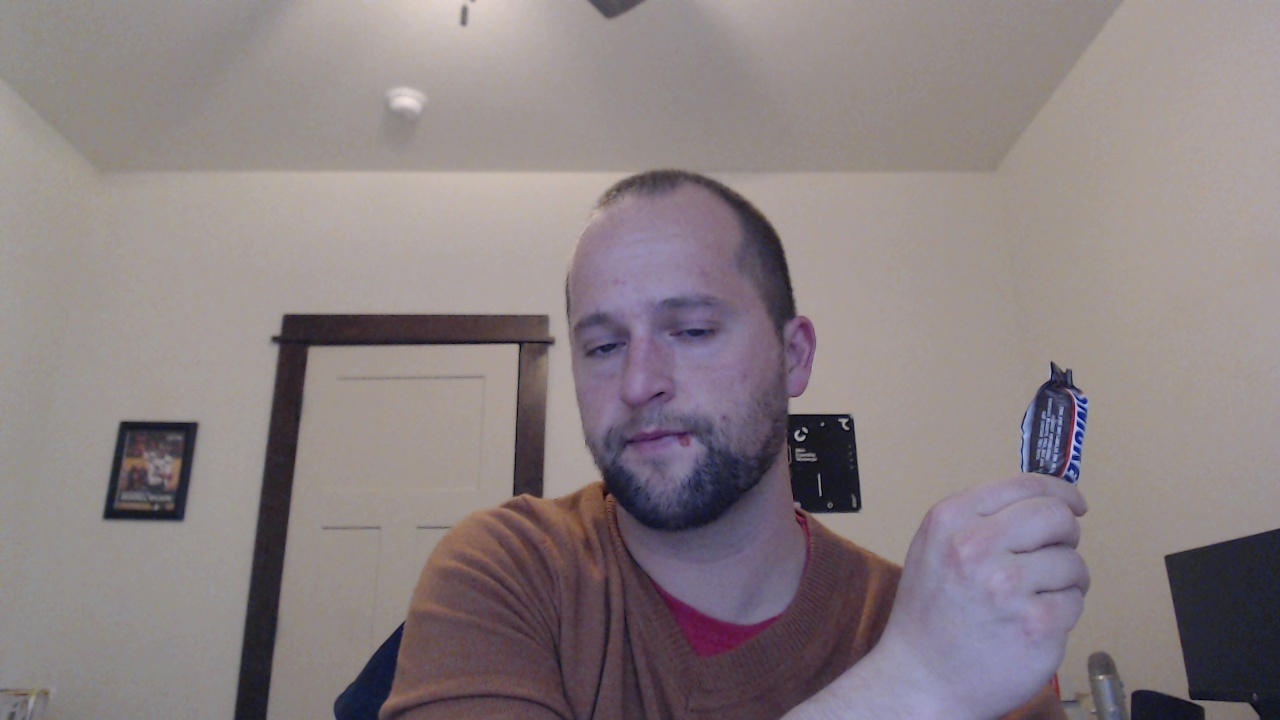

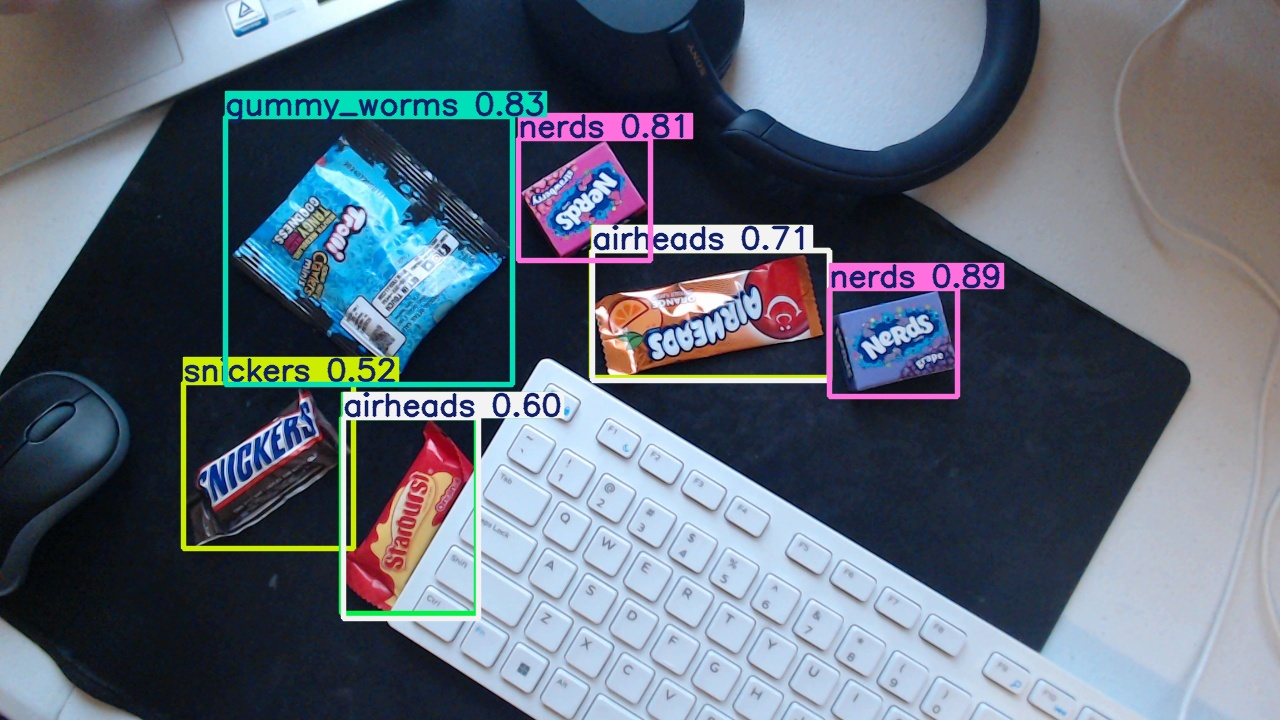

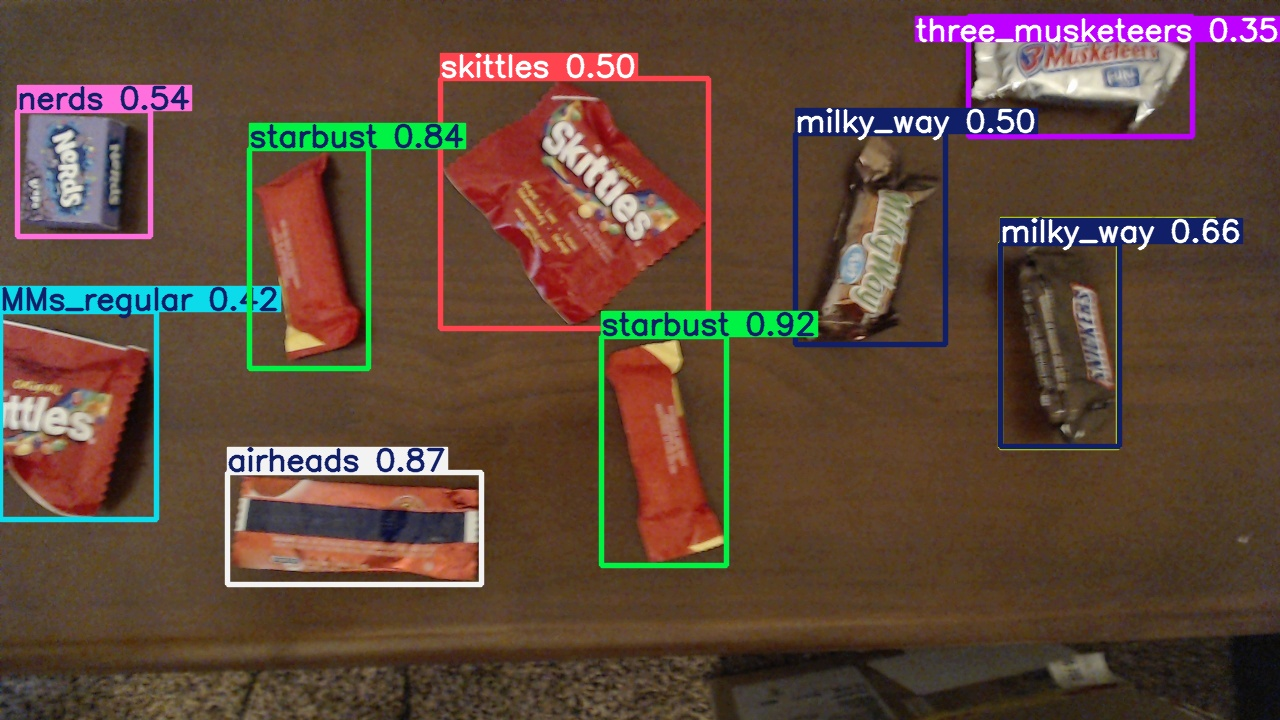

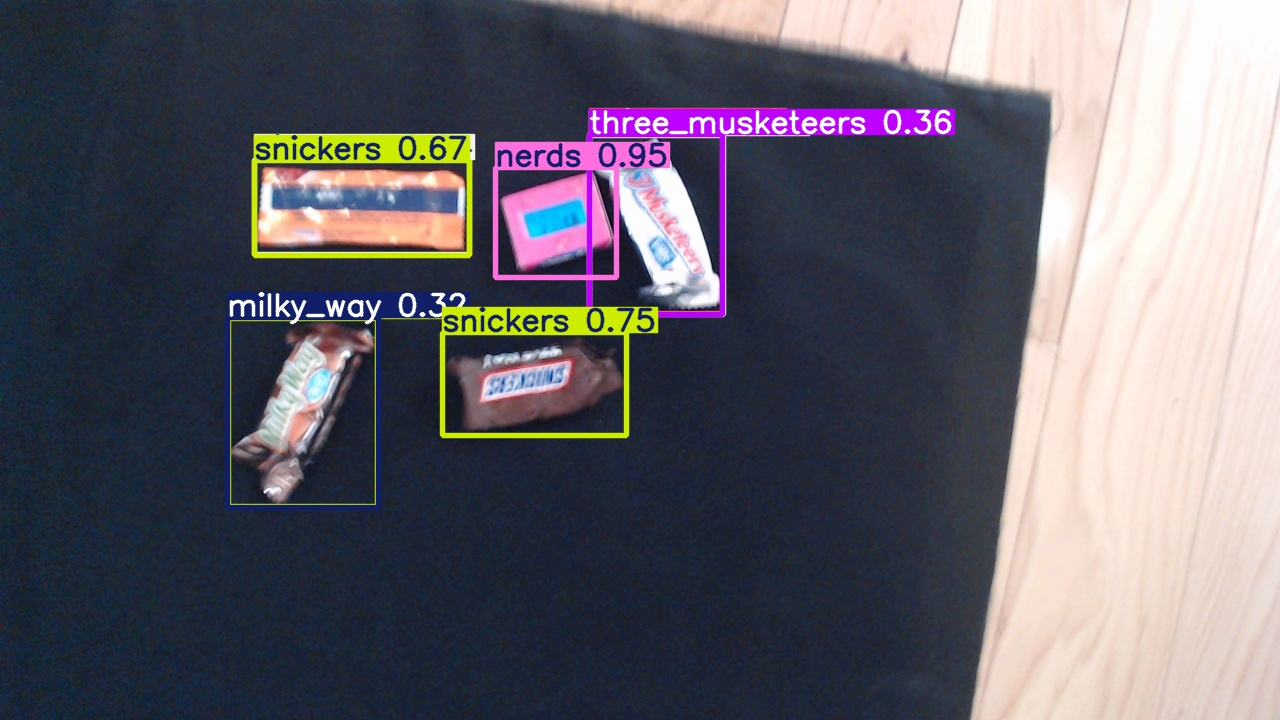

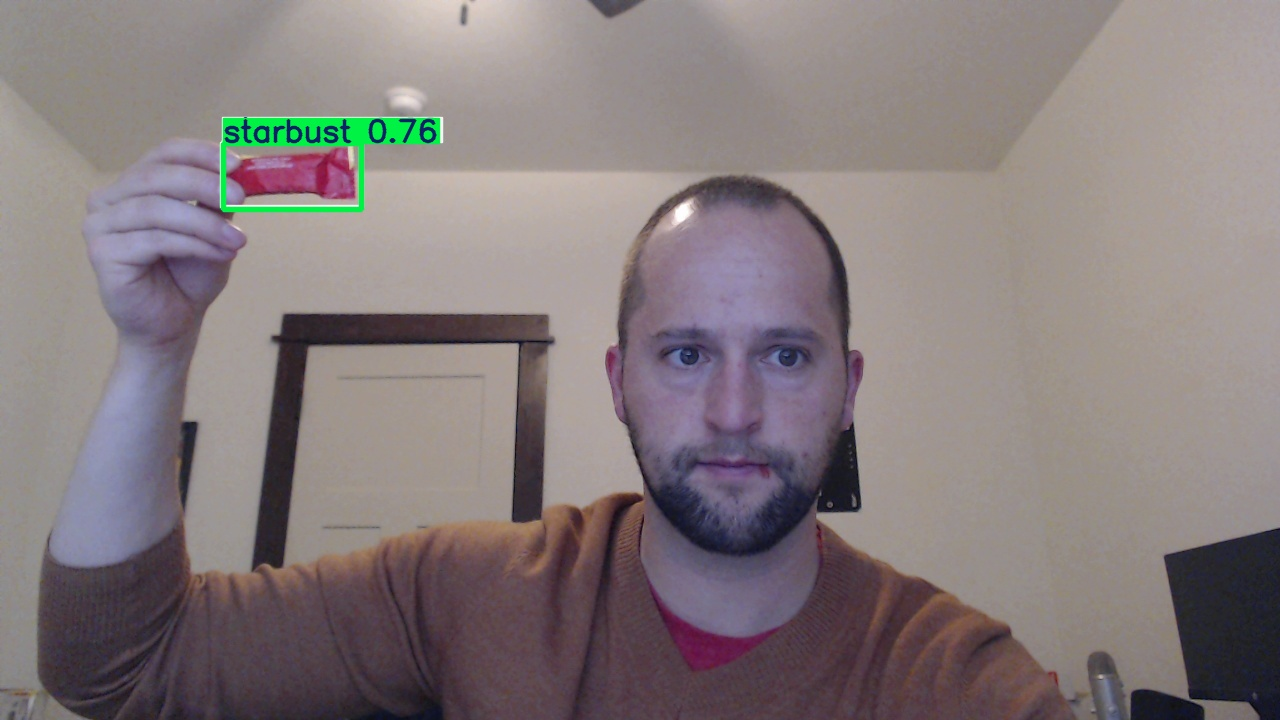

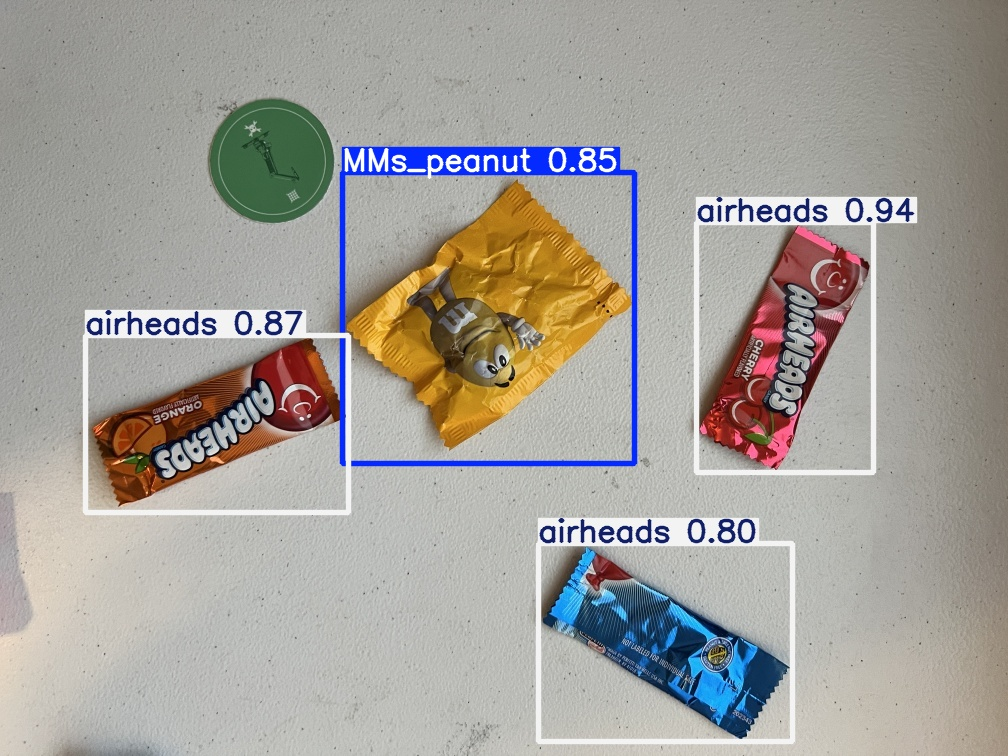

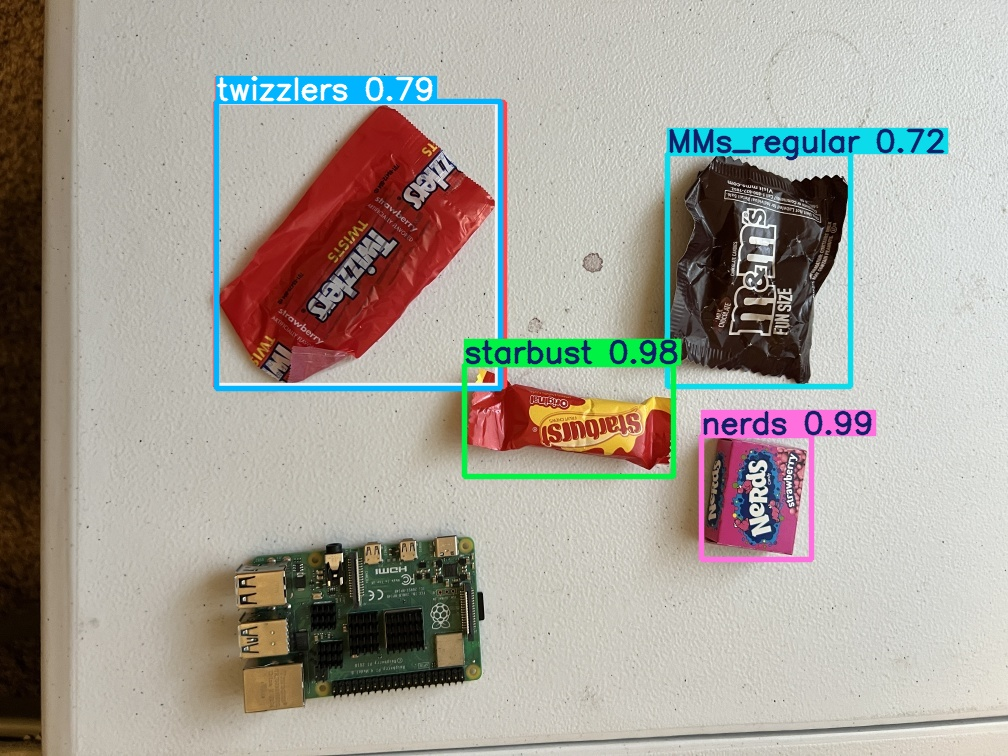

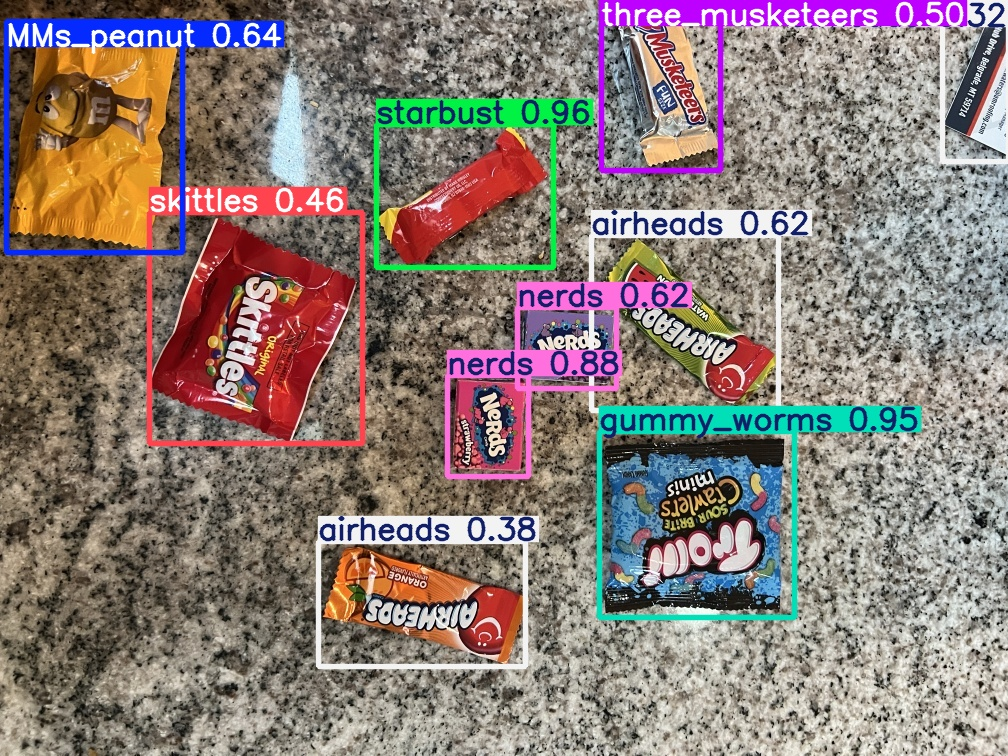

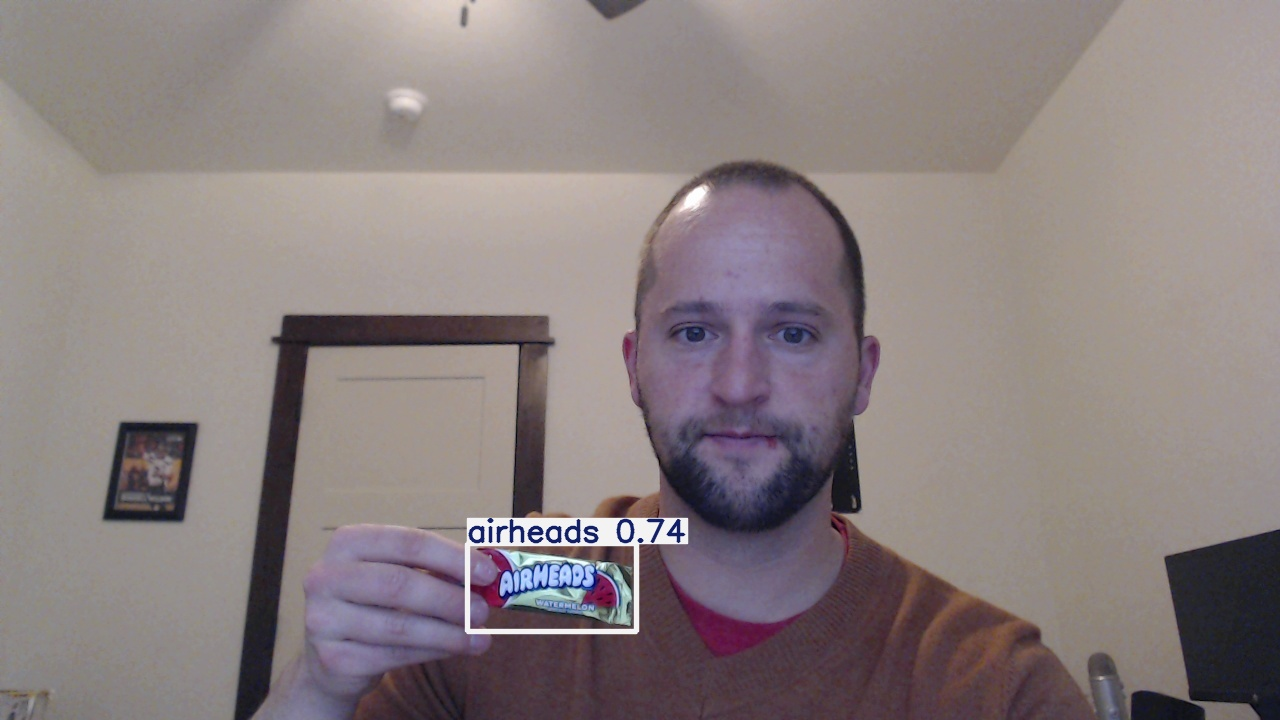

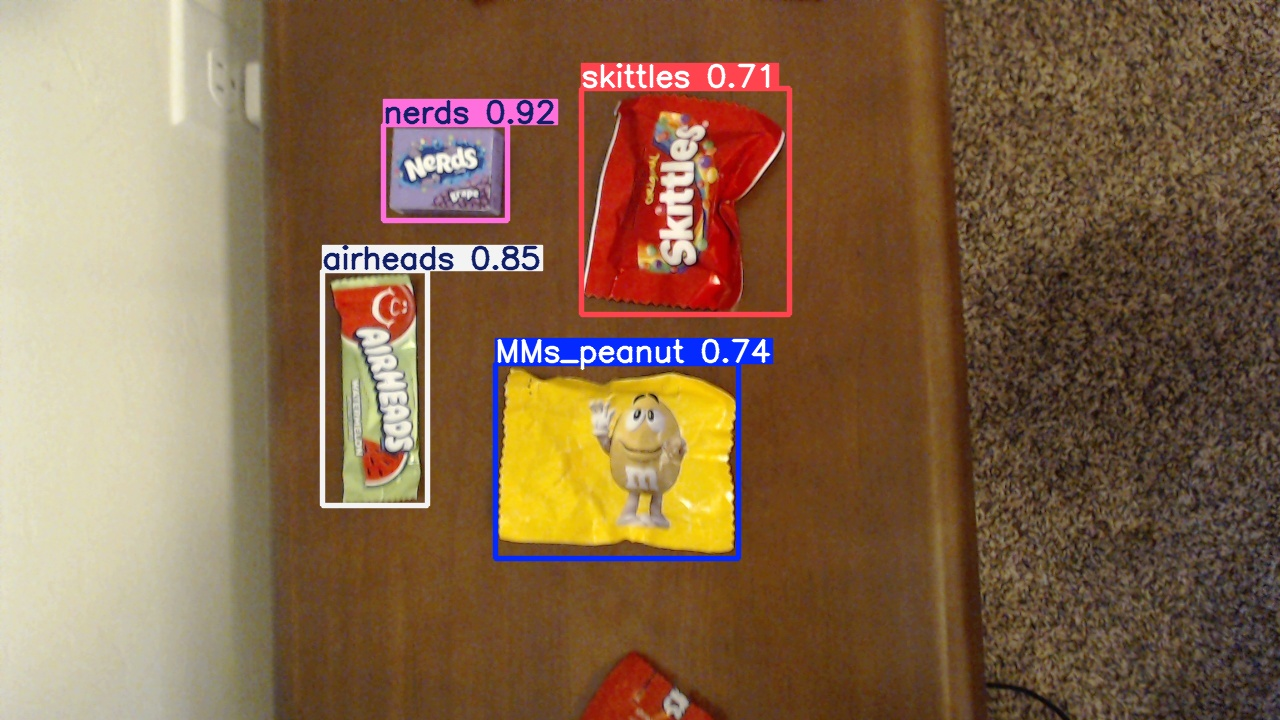

In [11]:
# Run predictions on validation images
val_images_path = 'data/validation/images'
predict_results = model.predict(
    source=val_images_path,
    conf=0.25,
    save=True,
    project='runs/detect',
    name='predict',
    exist_ok=True
)

print(f"✅ Predictions saved to: runs/detect/predict/")

# Display first 10 predictions
import glob
from IPython.display import Image as IPImage, display

pred_images = glob.glob('runs/detect/predict/*.jpg')[:10]

if pred_images:
    print(f"\nShowing first {len(pred_images)} predictions:\n")
    for img_path in pred_images:
        display(IPImage(filename=img_path, width=600))
        print('\n')
else:
    print("⚠️ No predictions found")

## 12. Export Model

Export the model to different formats for deployment.

In [12]:
# Export to ONNX format (most common)
print("Exporting model to ONNX format...")
onnx_path = model.export(format='onnx', dynamic=True)
print(f"✅ ONNX model exported to: {onnx_path}")

# Uncomment to export to other formats:
# coreml_path = model.export(format='coreml')  # For iOS/macOS
# tflite_path = model.export(format='tflite')  # For mobile/edge devices

Exporting model to ONNX format...
Ultralytics 8.3.219 🚀 Python-3.11.13 torch-2.9.0 CPU (Apple M2)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 15, 8400) (18.3 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim>=0.1.71', 'onnxruntime'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/18.3 MB ? eta -:--:--
   ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/18.3 MB 34.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━ 12.8/18.3 MB 33.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/663.8 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.8/663.8 kB 46.1 MB/s eta 0:00:00

   ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/3 [onnx]
   ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/3 [onnx]
   ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/3 [onnx]
   ━━━━━

ModuleNotFoundError: No module named 'onnx'

## 13. Run Inference on Custom Images

Test your model on any image!

In [ ]:
# Example: Run on a single image
# Replace 'path/to/your/image.jpg' with your image path

# test_image = 'path/to/your/image.jpg'
# results = model.predict(test_image, conf=0.25, save=True)

# # Display results
# for result in results:
#     boxes = result.boxes
#     print(f"Detected {len(boxes)} objects")
#     for box in boxes:
#         class_id = int(box.cls[0])
#         confidence = float(box.conf[0])
#         class_name = model.names[class_id]
#         print(f"  - {class_name}: {confidence:.2f}")

print("Uncomment the code above and replace the image path to test!")

## 14. Summary

### 🎉 Congratulations!

You've successfully trained a YOLO11 object detection model!

### 📁 Key Files:

- **Best model:** `runs/detect/train/weights/best.pt`
- **Last checkpoint:** `runs/detect/train/weights/last.pt`
- **Training plots:** `runs/detect/train/results.png`
- **Predictions:** `runs/detect/predict/`
- **ONNX model:** `runs/detect/train/weights/best.onnx`

### 🚀 Next Steps:

1. **Deploy on PC/Mac:**
   ```python
   from ultralytics import YOLO
   model = YOLO('runs/detect/train/weights/best.pt')
   results = model.predict('image.jpg')
   ```

2. **Deploy on Raspberry Pi:**
   - Convert to NCNN or TFLite format
   - Use Ultralytics CLI or Python API

3. **Improve Model:**
   - Add more training images
   - Increase epochs
   - Use larger model (yolo11m or yolo11l)
   - Tune hyperparameters

### 📚 Resources:

- [Ultralytics Documentation](https://docs.ultralytics.com/)
- [YOLO GitHub](https://github.com/ultralytics/ultralytics)
- [EdjeElectronics Tutorial](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models)

---

**Happy detecting!** 🎯